In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/SWM_Project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1kN9YxqZQx6TWrX5kRlCxIDlOIDfX1KQg/SWM_Project


**Importing Libraries**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA

import sqlite3
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from time import time

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import seaborn as sns
from tqdm import tqdm

pd.options.mode.chained_assignment = None

**Load Data From Database**

In [ ]:
print("Loading Data from Database")
conn = sqlite3.connect("yelpDataset.db")
conn.text_factory = lambda x: str(x, 'gb2312', 'ignore')
cursor = conn.cursor()

# Create User DataFrame
cursor.execute("SELECT * FROM user")
user_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])

# Create Reviews DataFrame
cursor.execute(
    "SELECT reviewID, reviewerID, restaurantID, date, rating, usefulCount as reviewUsefulCount, reviewContent, flagged FROM review WHERE flagged in ('Y','N')")
reviews_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])

# Create Business DataFrame
cursor.execute("SELECT restaurantID, rating as restaurantRating FROM business")
business_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])

# Merge all 3 tables as one Dataframe
rr_df = reviews_df.merge(reviews_df, on='reviewerID', how='inner')
df = rr_df.merge(business_df, on='restaurantID', how='inner')

print("Data Load Complete")

Loading Data from Database
Data Load Complete


**Data Cleaning**

In [ ]:
!python -m nltk.downloader all

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sh: 0: getcwd() failed: No such file or directory
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downlo

In [ ]:
print("Cleaning Data")
# Removing \n from date field
for i in range(len(df['date'])):
    if df['date'][i][0] == '\n':
        df['date'][i] = df['date'][i][1:]

# Making yelpJoinDate Format Uniform
try:
  df['yelpJoinDate'] = df['yelpJoinDate'].apply(lambda x: datetime.strftime(datetime.strptime(x, '%B %Y'), '01/%m/%Y'))
except:
  pass

# Pre-processing Text Reviews
# Lowercase Words
df['reviewContent'] = df['reviewContent'].apply(lambda x: x.lower())

# Remove Punctuations
tokenizer = RegexpTokenizer(r'\w+')
df['reviewContent'] = df['reviewContent'].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x)))

# Remove Stop Words
stop = stopwords.words('english')
df['reviewContent'] = df['reviewContent'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop))

print("Data Cleaning Complete")

Cleaning Data
Data Cleaning Complete


**Feature Extraction**

In [ ]:
#Generating features from the original DataFrame
print("Feature Engineering: Creating New Features")
max_df1 = df[['reviewerID', 'date']].copy()
max_df2 = max_df1.groupby(by=['date', 'reviewerID']).size().reset_index(name='max_rev')
max_df2['max_rev'] = max_df2['max_rev'] / max_df2['max_rev'].max()
df = df.merge(max_df2, on=['reviewerID', 'date'], how='inner')

df['rev_word_len'] = df['reviewContent'].apply(lambda x: len(x.split()))
df['rev_dev'] = abs(df['rating'] - df['restaurantRating']) / 4

reviews_data = df
res = OrderedDict()

for row in reviews_data.iterrows():
    if row[1].reviewerID in res:
        res[row[1].reviewerID].append(row[1].reviewContent)
    else:
        res[row[1].reviewerID] = [row[1].reviewContent]

individual_user = [{'reviewerID': k, 'reviewContent': v} for k, v in res.items()]
df2 = dict()
df2['reviewerID'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1
for reviewer_data in individual_user:
    count = count + 1
    try:
        tfidf = vector.fit_transform(reviewer_data['reviewContent'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    if max == -np.inf:
        max = 0
    df2['reviewerID'][count] = reviewer_data['reviewerID']
    df2['Maximum Content Similarity'][count] = max

df3 = pd.DataFrame(df2, columns=['reviewerID', 'Maximum Content Similarity'])

df = pd.merge(reviews_data, df3, on="reviewerID", how="left")
df['review_len'] = df['reviewContent'].apply(lambda x: len(x))
df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True)
print("Feature Engineering Complete")

Feature Engineering: Creating New Features


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Feature Engineering Complete


In [ ]:
df.columns

Index(['reviewID', 'reviewerID', 'restaurantID', 'date', 'rating',
       'reviewUsefulCount', 'reviewContent', 'flagged', 'name', 'location',
       'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount',
       'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount',
       'fanCount', 'restaurantRating', 'max_rev', 'rev_word_len', 'rev_dev',
       'Maximum Content Similarity', 'review_len'],
      dtype='object')

In [ ]:
df['flagged'] = df['flagged'].apply(lambda x: 0 if x=='N' else 1)
df = df.drop(columns=['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'reviewContent'])
df.head()

,rating,reviewUsefulCount,flagged,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,max_rev,rev_word_len,rev_dev,Maximum Content Similarity,review_len
0,5,0,0,11,48,5,41,5,5,2,0,1,4.5,0.1,497,0.125,0.123653,3226
1,5,0,0,0,4,0,0,0,0,0,0,0,4.5,0.1,41,0.125,0.000000,251
2,3,8,0,84,60,1,35,8,6,6,11,0,4.5,0.1,244,0.375,0.000000,1593
3,5,1,0,333,1209,61,1650,679,417,283,22,70,4.5,0.1,97,0.125,0.758992,638
4,5,3,0,59,54,1,68,20,37,12,0,4,4.5,0.1,236,0.125,0.000000,1548


**Balancing the Data using Under Sampling**

In [ ]:
print("Under-Sampling Data")

#Generate labels
genuine_reviews_df = df[df['flagged'] == 0]
fake_reviews_df = df[df['flagged'] == 1]
sample_size = len(df[(df['flagged'] == 1)])

authentic_reviews_us_df = genuine_reviews_df.sample(sample_size)
df = pd.concat([authentic_reviews_us_df, fake_reviews_df], axis=0)

print("Under-Sampling Complete")

Under-Sampling Data
Under-Sampling Complete


**Confusion Matrix**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt

In [ ]:
labels = df['flagged']
data_df = df.drop(columns=['flagged'])
train_data, test_data, train_label, test_label = train_test_split(data_df, labels, test_size=0.2, random_state=42)


In [ ]:
# Logistic Regression

def logistic_regression(tr_df, ts_df, tr_label, ts_label, name):

    lg_clf = LogisticRegression(random_state=0).fit(tr_df, tr_label)

    lg_preds = lg_clf.predict(ts_df)
    print(confusion_matrix(ts_label,lg_preds))
    print(classification_report(ts_label,lg_preds))

    plot_confusion_matrix(ts_label, lg_preds, classes=['N', 'Y'],
                              title=name+' Confusion Matrix').show()
    
# Random Forest Classifier

def rf_classifier(tr_df, ts_df, tr_label, ts_label, name):
    rf_clf = RandomForestClassifier(max_depth=8, random_state=0)
    rf_clf.fit(tr_df, tr_label)

    rf_preds = rf_clf.predict(ts_df)
    print(confusion_matrix(ts_label,rf_preds))
    print(classification_report(ts_label,rf_preds))

    plot_confusion_matrix(ts_label, rf_preds, classes=['N', 'Y'],
                              title=name+' Confusion Matrix').show()

    
# SVM Classifier with Cross Validation

def svm_classifier(tr_df, ts_df, tr_label, ts_label, name):

    svm_clf = svm.SVC(class_weight='balanced')

    grid = GridSearchCV(
        svm_clf,
        cv=5,
        n_jobs=1,
        param_grid={'C': [0.01, 1, 10, 100]},
        scoring=['precision', 'recall', 'f1', 'accuracy'],
        refit='accuracy',
        verbose=2
    )
    grid.fit(tr_df, tr_label)

    svm_preds = grid.predict(ts_df)
    print(confusion_matrix(ts_label,svm_preds))
    print(classification_report(ts_label,svm_preds))

    plot_confusion_matrix(ts_label, svm_preds, classes=['N', 'Y'],
                              title=name+' Confusion Matrix').show()


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[[ 828  307]
 [  59 1002]]
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1135
           1       0.77      0.94      0.85      1061

    accuracy                           0.83      2196
   macro avg       0.85      0.84      0.83      2196
weighted avg       0.85      0.83      0.83      2196



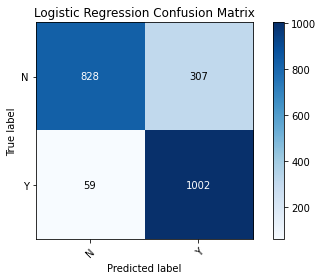

In [ ]:
# Logistic Regression with original features

logistic_regression(train_data, test_data, train_label, test_label, 'Logistic Regression')

[[943 192]
 [ 87 974]]
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1135
           1       0.84      0.92      0.87      1061

    accuracy                           0.87      2196
   macro avg       0.88      0.87      0.87      2196
weighted avg       0.88      0.87      0.87      2196



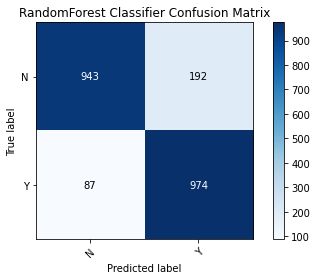

In [ ]:
# RF with original features

rf_classifier(train_data, test_data, train_label, test_label, 'RandomForest Classifier')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time=   5.3s
[CV] END .............................................C=0.01; total time=   5.0s
[CV] END .............................................C=0.01; total time=   5.0s
[CV] END .............................................C=0.01; total time=   6.3s
[CV] END .............................................C=0.01; total time=   4.8s
[CV] END ................................................C=1; total time=   3.2s
[CV] END ................................................C=1; total time=   3.2s
[CV] END ................................................C=1; total time=   3.2s
[CV] END ................................................C=1; total time=   3.2s
[CV] END ................................................C=1; total time=   3.2s
[CV] END ...............................................C=10; total time=   2.8s
[CV] END ........................................

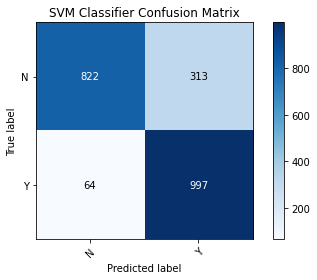

In [ ]:
# SVM Classifier with original features

svm_classifier(train_data, test_data, train_label, test_label, 'SVM Classifier')

In [ ]:
# Feature Selection using Random Forest

def rf_feature_sel(temp_df):
    feature_sel_df = temp_df.copy()

    sel = SelectFromModel(RandomForestClassifier(n_estimators=500), max_features=12, threshold=-np.inf)

    sel.fit(feature_sel_df, train_label)
    print(len(sel.get_support()))
    print(feature_sel_df.columns[sel.get_support()])
    
    return feature_sel_df.columns[sel.get_support()]

rf_features = rf_feature_sel(train_data)

17
Index(['reviewUsefulCount', 'friendCount', 'reviewCount', 'firstCount',
       'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'fanCount',
       'rev_word_len', 'Maximum Content Similarity', 'review_len'],
      dtype='object')


**HeatMap**

In [ ]:
# plot 1 : single

In [ ]:
# RF selected features correlation heatmap\

import matplotlib.pyplot as plt
import plotly.graph_objects as go

rf_df = df[rf_features]
fig = go.Figure(
    data=go.Heatmap(
        x=list(rf_df.columns),
        y=list(rf_df.columns),
        z=rf_df.corr(),
        colorscale='Portland'
    ))
fig.update_layout(title='RF Selected Features Correlation', title_x=0.5, width=600, height=600)
fig.show()

In [ ]:
# plot 2 (add side by side : 2 in a row, each feature is a single plot)

In [ ]:
import plotly.figure_factory as ff
k = 5
rf_fd_df = rf_df.copy()
rf_fd_df['flagged'] = labels
most_correlated_columns = list(rf_fd_df.corr()['flagged'].abs().sort_values(ascending=False).index[1:k+1])
feature_columns = most_correlated_columns
for feature_col in feature_columns:
    try:
    # Group data together
        hist_data = []
        group_labels = []
        for group in list(rf_fd_df['flagged'].unique()):
            hist_data.append(df[rf_fd_df['flagged']==group][feature_col].to_numpy())
            group_labels.append('Class: ' + str(group))
        # Create distplot with custom bin_size
        fig = ff.create_distplot(
            hist_data, group_labels, bin_size=.01
        )
        fig.update_layout(
            title='Distribution of \'' + feature_col + '\' by Class',
            title_x=0.5, xaxis_title='Feature Value', yaxis_title='Frequency',
            width=500, height=500
        )
        fig.show()
        
    except:
        pass

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[[ 843  292]
 [  58 1003]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1135
           1       0.77      0.95      0.85      1061

    accuracy                           0.84      2196
   macro avg       0.86      0.84      0.84      2196
weighted avg       0.86      0.84      0.84      2196



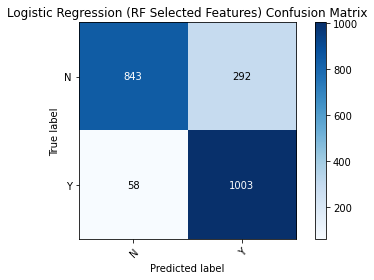

In [ ]:
# Logistic Regression with RF selected Features

logistic_regression(train_data[rf_features], test_data[rf_features], train_label, test_label, 'Logistic Regression (RF Selected Features)')

[[935 200]
 [ 91 970]]
              precision    recall  f1-score   support

           0       0.91      0.82      0.87      1135
           1       0.83      0.91      0.87      1061

    accuracy                           0.87      2196
   macro avg       0.87      0.87      0.87      2196
weighted avg       0.87      0.87      0.87      2196



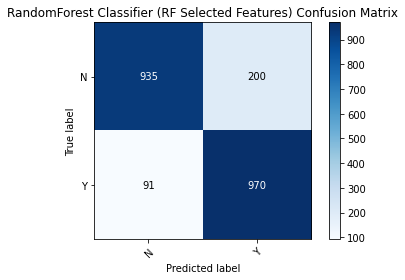

In [ ]:
rf_classifier(train_data[rf_features], test_data[rf_features], train_label, test_label, 'RandomForest Classifier (RF Selected Features)')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time=   5.1s
[CV] END .............................................C=0.01; total time=   4.9s
[CV] END .............................................C=0.01; total time=   4.8s
[CV] END .............................................C=0.01; total time=   4.8s
[CV] END .............................................C=0.01; total time=   4.8s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ................................................C=1; total time=   3.2s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ...............................................C=10; total time=   2.8s
[CV] END ........................................

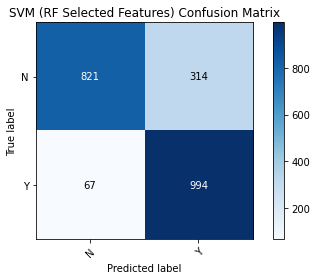

In [ ]:
# SVM with RF selected features
 
svm_classifier(train_data[rf_features], test_data[rf_features], train_label, test_label, 'SVM (RF Selected Features)')

In [ ]:
# PCA Dimensionality Reduction

def pca_dim_red(temp_df):
    pca_df = temp_df.copy()

    pca = PCA(n_components=12)

    print("Dimensions before PCA", len(temp_df.columns))

    princi = pca.fit_transform(pca_df)
    pdf = pd.DataFrame(data=princi)
    print("Reduced Dimensions to ", len(pdf.columns))
    return pdf

In [ ]:
pca_df = pca_dim_red(df)

train_data_pca, test_data_pca, train_label_pca, test_label_pca = train_test_split(pca_df, labels, test_size=0.2, random_state=42)


Dimensions before PCA 18
Reduced Dimensions to  12


In [ ]:
pca_df


,0,1,2,3,4,5,6,7,8,9,10,11
0,-97.208043,1255.719863,99.936273,65.627315,25.391801,13.379499,-3.200851,0.909231,5.449323,-0.338415,2.362122,-0.415248
1,-222.365787,-341.480870,12.300766,18.266442,7.228946,6.986770,2.354071,-3.137179,0.383997,-0.542043,2.020545,0.952322
2,-77.732473,190.798856,-29.670277,-21.214607,11.675543,1.465109,-9.569739,-17.902663,7.939403,2.833043,-6.379009,1.328611
3,-138.173570,119.044107,4.236988,12.559531,-2.877321,10.125360,-1.491332,-18.732641,7.583207,1.262224,-3.214873,1.260246
4,-214.581768,-232.647901,17.760855,18.257583,4.907916,5.712993,0.572453,0.065823,-0.176683,-0.134364,-2.485005,0.120670
...,...,...,...,...,...,...,...,...,...,...,...,...
10975,-209.925909,-54.767794,34.434630,28.120276,15.285796,10.796285,1.461468,-1.264628,1.949104,-0.379335,0.348970,0.098813
10976,-208.425412,-34.123338,37.244375,30.148328,17.402426,11.867875,1.729821,-2.074542,2.448188,-1.246925,8.804875,0.892115
10977,-186.871921,297.688352,56.806922,36.597387,22.062938,15.558071,1.417929,-0.800069,3.228757,0.001644,-2.658733,0.306762
10978,-219.614131,-210.883263,25.503834,26.969934,14.498019,9.733840,1.803145,-2.673335,1.959006,-0.710775,4.100401,-3.096784


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[[ 539  596]
 [  23 1038]]
              precision    recall  f1-score   support

           0       0.96      0.47      0.64      1135
           1       0.64      0.98      0.77      1061

    accuracy                           0.72      2196
   macro avg       0.80      0.73      0.70      2196
weighted avg       0.80      0.72      0.70      2196



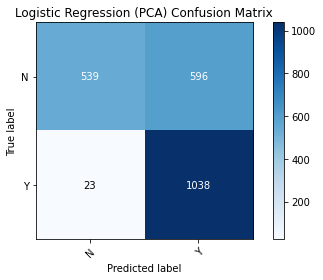

In [ ]:
logistic_regression(train_data_pca, test_data_pca, train_label_pca, test_label_pca, 'Logistic Regression (PCA)')

[[910 225]
 [138 923]]
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1135
           1       0.80      0.87      0.84      1061

    accuracy                           0.83      2196
   macro avg       0.84      0.84      0.83      2196
weighted avg       0.84      0.83      0.83      2196



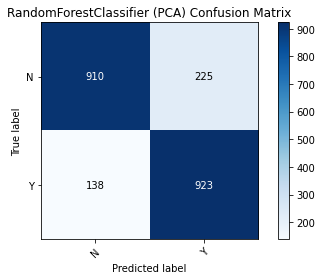

In [ ]:
# Random Forest PCA
    
rf_classifier(train_data_pca, test_data_pca, train_label_pca, test_label_pca, 'RandomForestClassifier (PCA)')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .............................................C=0.01; total time=   5.7s
[CV] END .............................................C=0.01; total time=   4.8s
[CV] END .............................................C=0.01; total time=   4.8s
[CV] END .............................................C=0.01; total time=   4.9s
[CV] END .............................................C=0.01; total time=   4.7s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ................................................C=1; total time=   3.1s
[CV] END ................................................C=1; total time=   3.2s
[CV] END ...............................................C=10; total time=   2.7s
[CV] END ........................................

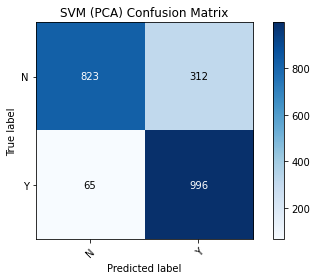

In [ ]:
# SVM PCA

svm_classifier(train_data_pca, test_data_pca, train_label_pca, test_label_pca, 'SVM (PCA)')